# Import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

#Visualization Import

import seaborn as sns
import matplotlib.pyplot as plt

# Model Import
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor

intake_outcome_df = pd.read_csv('aac_intakes_outcomes.csv')
breed_df = pd.read_csv('akc_breed_info.csv')
# remove non-numeric values from df
breed_df = breed_df[pd.to_numeric(breed_df['weight_high_lbs'], errors='coerce').notnull()]

# standardize column case and remove spaces
intake_outcome_df.columns = intake_outcome_df.columns.str.lower()
intake_outcome_df.columns = intake_outcome_df.columns.str.replace(' ', '_')

# Remove duplicate values from the dataset
intake_outcome_df = intake_outcome_df[~intake_outcome_df.duplicated(keep='last')]

# Limit to dog adoptions
columns_to_keep = ['intake_monthyear','outcome_type','sex_upon_outcome', 'sex_upon_intake', 'intake_month','intake_year','age_upon_intake_(years)','breed', 'color', 'intake_condition', 'intake_type', 'time_in_shelter_days']
dog_adoption_df = intake_outcome_df[intake_outcome_df['animal_type'] == 'Dog'][columns_to_keep].reset_index()
dog_adoption_df.drop('index', axis=1, inplace=True)

# Exploratory Data Analysis

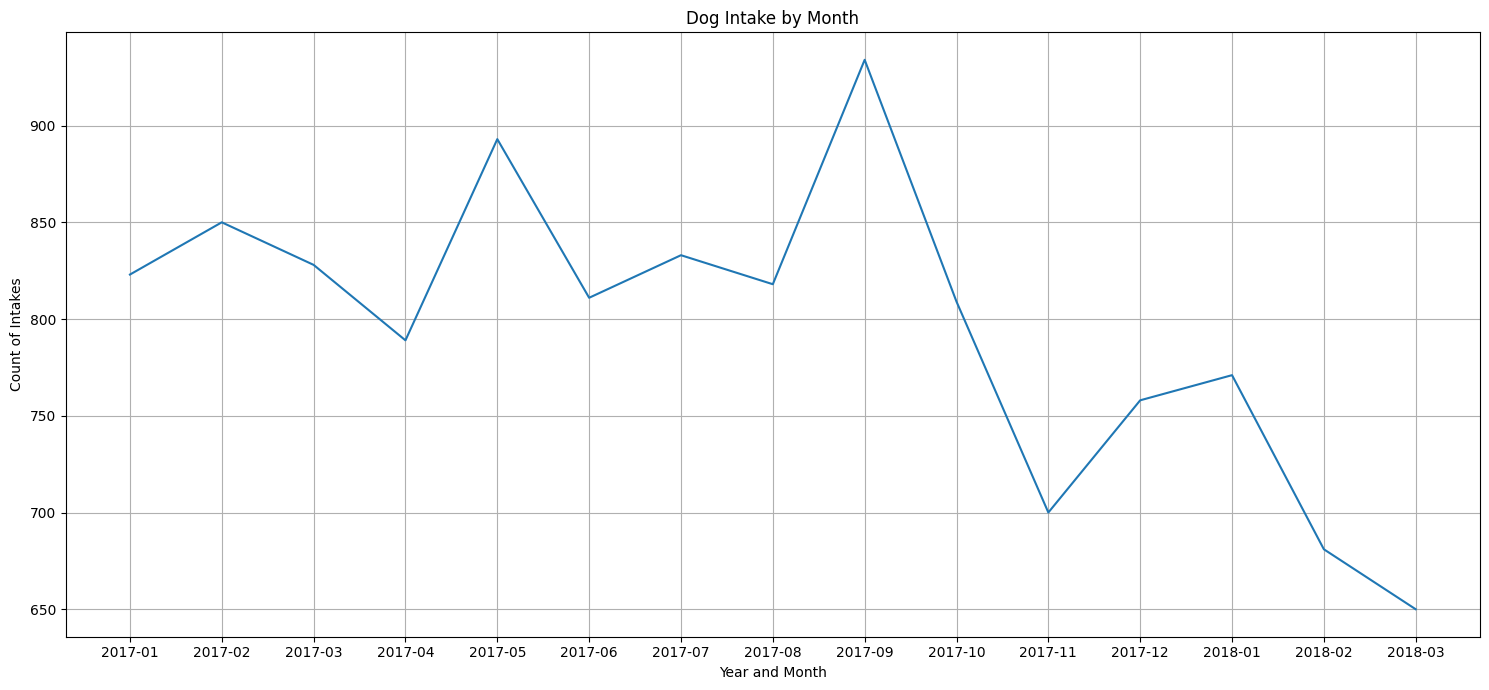

In [2]:
# Intake by month
intake_month_df = dog_adoption_df[dog_adoption_df['intake_year'] > 2016].groupby(['intake_monthyear']).agg(intake_count=('time_in_shelter_days','count')).reset_index()
fig = plt.figure(figsize=(15,7))
sns.lineplot(x='intake_monthyear',y='intake_count', data=intake_month_df)
plt.title('Dog Intake by Month')
plt.xlabel('Year and Month')
plt.ylabel('Count of Intakes')
plt.tight_layout()
plt.grid()
plt.show()

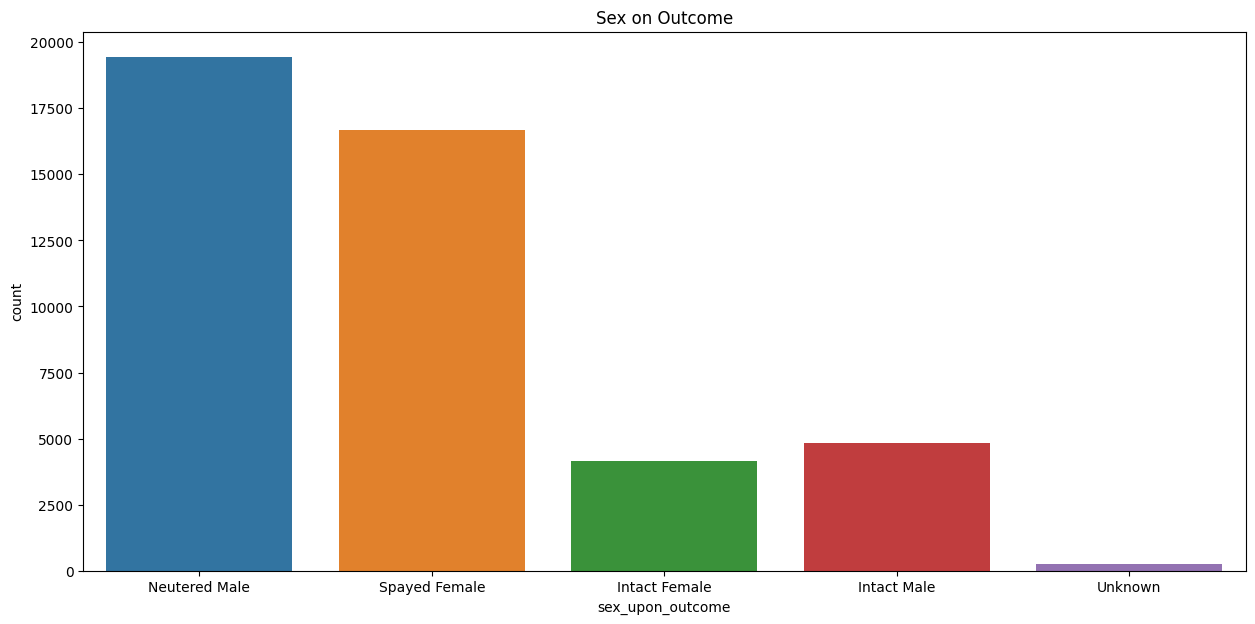

In [3]:
# sex on outcome
fig = plt.figure(figsize=(15,7))
sns.countplot(x='sex_upon_outcome', data=dog_adoption_df)
plt.title('Sex on Outcome')
plt.show()


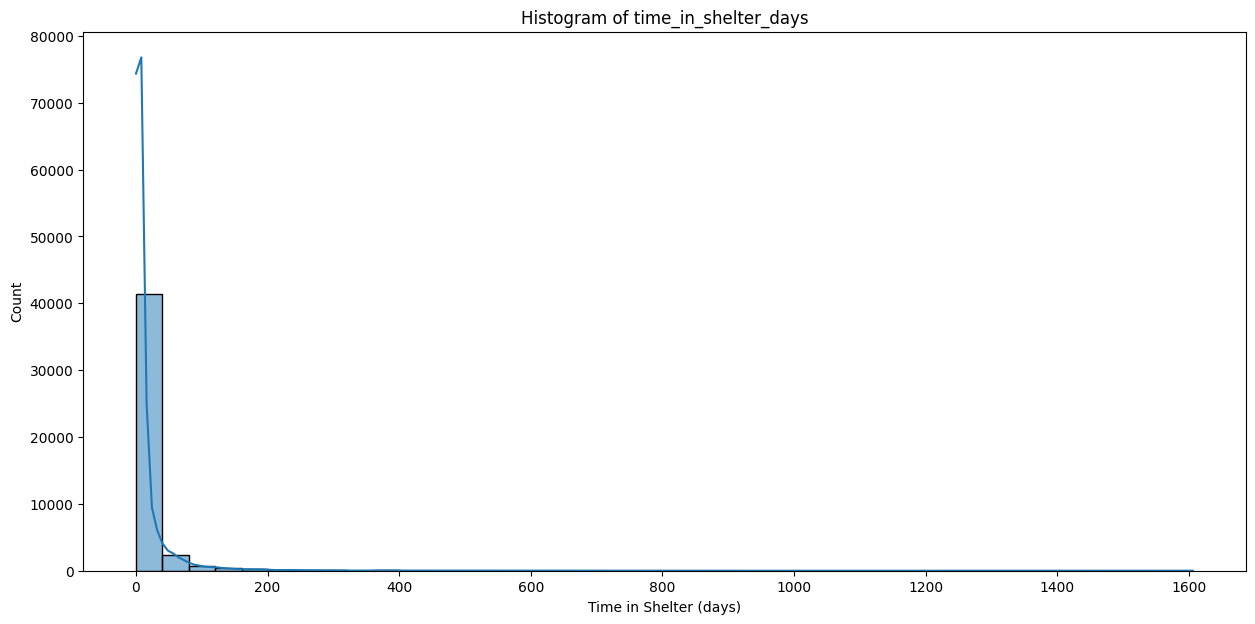

In [4]:
# histogram of time_in_shelter_days
fig = plt.figure(figsize=(15,7))
sns.histplot(dog_adoption_df['time_in_shelter_days'], bins=40, kde=True)
plt.title('Histogram of time_in_shelter_days')
plt.xlabel('Time in Shelter (days)')
plt.show()

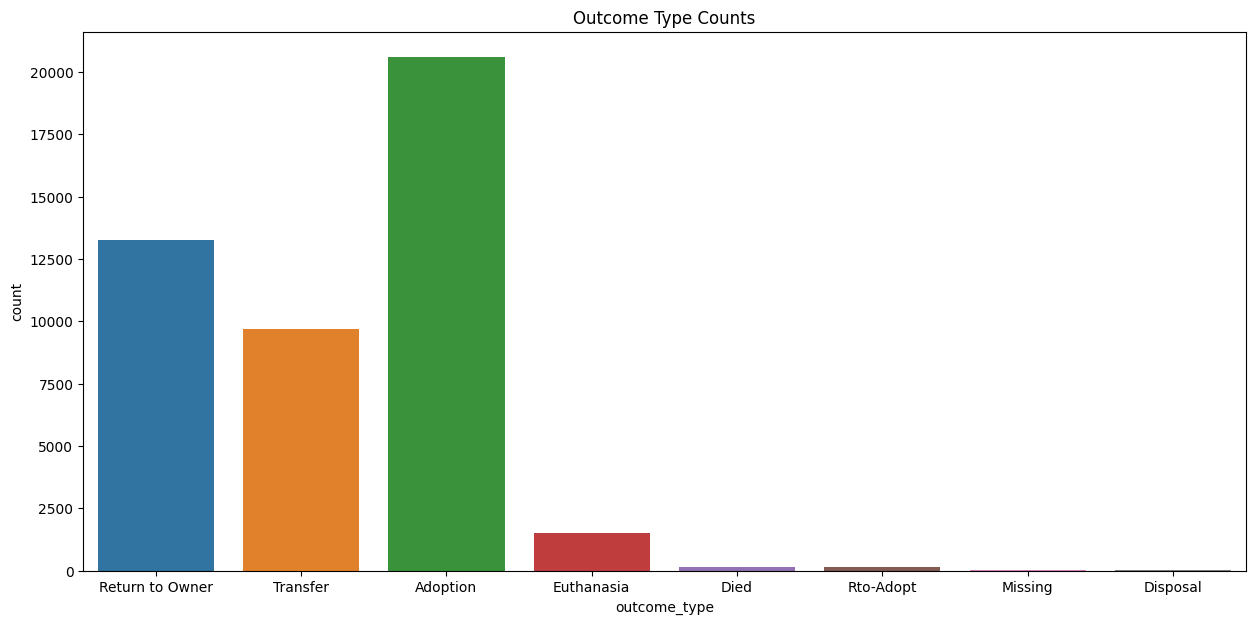

In [5]:
# outcome type
fig = plt.figure(figsize=(15,7))
sns.countplot(x='outcome_type', data=dog_adoption_df)
plt.title('Outcome Type Counts')
plt.show()

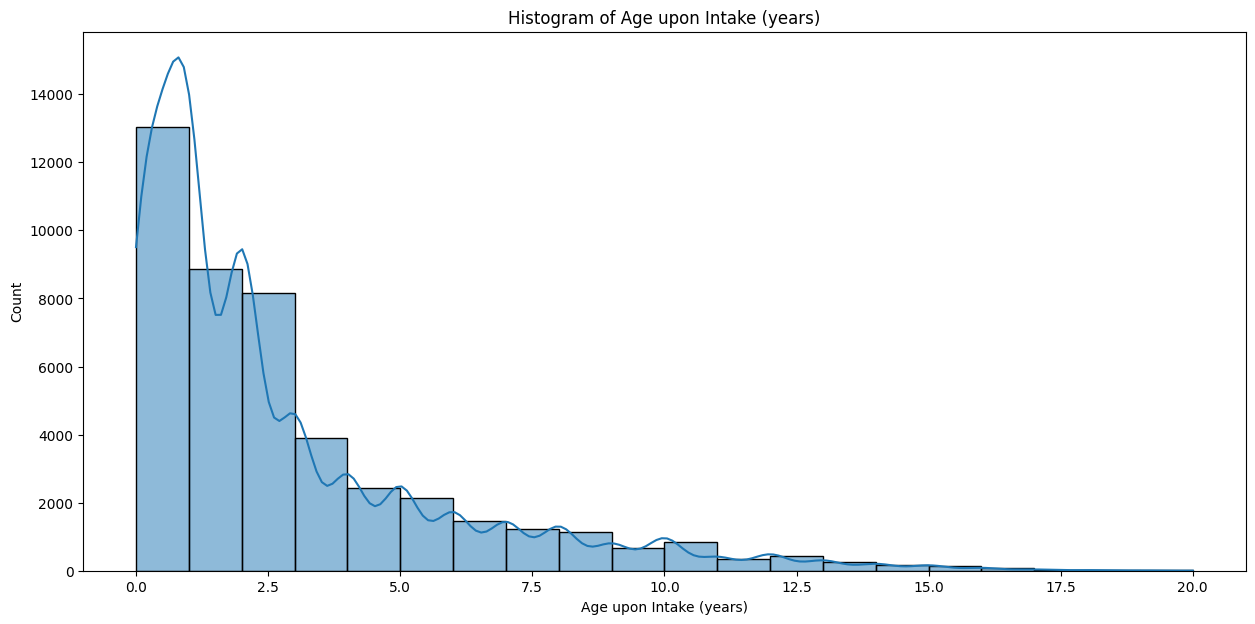

In [6]:
# histogram of age
fig = plt.figure(figsize=(15,7))
sns.histplot(dog_adoption_df['age_upon_intake_(years)'], bins=20, kde=True)
plt.title('Histogram of Age upon Intake (years)')
plt.xlabel('Age upon Intake (years)')
plt.show()

# Data Pre-Processing

In [7]:
# Drop records with NULLs

dog_adoption_df.dropna(inplace=True)

# Add Mix Flag
dog_adoption_df['mix_flg'] = np.where((dog_adoption_df['breed'].str.contains('Mix', case=False)) | (dog_adoption_df['breed'].str.contains('/', case=False)), 1, 0)
dog_adoption_df['breed_join'] = dog_adoption_df['breed'].str.split("/", n = 1, expand = False).str[0]
# remove Mix from breed
dog_adoption_df['breed'] = dog_adoption_df['breed'].str.replace(' Mix', '')
# split dog breed into list
dog_adoption_df['breed'] = dog_adoption_df['breed'].str.split("/", expand = False)
# create a dummy variable for each breed
breed_dummies = pd.get_dummies(dog_adoption_df['breed'].apply(pd.Series).stack()).groupby(level=0).sum()
prefix = 'breed_'
breed_dummies.columns = [prefix + col for col in breed_dummies.columns]
dog_adoption_df = dog_adoption_df.join(breed_dummies)
dog_adoption_df.drop('breed', inplace=True, axis=1)
# function that determines ratio and token
def metrics(tup):
    return pd.Series([fuzz.ratio(*tup),
                      fuzz.token_sort_ratio(*tup)],
                     ['ratio', 'token'])
# create multi index to use fuzzy match
compare = pd.MultiIndex.from_product([breed_df['breed'],
                                      dog_adoption_df['breed_join'].unique()]).to_series()
# Create reference to join views
breed_fuzzy = compare.apply(metrics).unstack().idxmax().unstack(0).reset_index()
# fix matches found by manually checking file
def update_ratio(index, ratio):
    if index in ['American Bulldog','American Bulldog Mix','English Bulldog','English Bulldog Mix','Old English Bulldog']:
        return 'Bull Dog'
    elif index in ['Lhasa Apso','Lhasa Apso Mix']:
        return 'Tibetan Terrier'
    elif index in ['Miniature Pinscher','Miniature Pinscher Mix']:
        return 'Dachshund'
    elif index in ['Pit Bull','Pit Bull Mix']:
        return 'American Staffordshire Terrier'
    elif index in ['Alaskan Malamute','Alaskan Malamute Mix']:
        return 'Siberian Husky'
    else:
        return ratio
breed_fuzzy['ratio'] = breed_fuzzy[['index','ratio']].apply(lambda breed_fuzzy: update_ratio(breed_fuzzy['index'],breed_fuzzy['ratio']),axis=1)
breed_fuzzy = breed_fuzzy[['index','ratio']].rename(columns={'index' : 'breed_join', 'ratio' : 'breed_primary'})
# join the fuzzy match df in order to bring in the weight / length df into the intake df
dog_adoption_df = pd.merge(dog_adoption_df, breed_fuzzy, how='left', left_on='breed_join', right_on='breed_join')
# adding weight / length data into dataframe
dog_adoption_df = pd.merge(dog_adoption_df, breed_df, how='left', left_on='breed_primary', right_on='breed').drop('breed', axis = 1)

# break out colors
dog_adoption_df['color'] = dog_adoption_df['color'].str.split("/", expand = False)
# create a dummy variable for each breed
color_dummies = pd.get_dummies(dog_adoption_df['color'].apply(pd.Series).stack()).groupby(level=0).sum()
prefix = 'color_'
color_dummies.columns = [prefix + col for col in color_dummies.columns]

dog_adoption_df = pd.get_dummies(dog_adoption_df, columns=['intake_condition'], drop_first=True) 
dog_adoption_df = pd.get_dummies(dog_adoption_df, columns=['intake_type'], drop_first=True) 

# Create a new column 'male_flg'
dog_adoption_df['male_flg'] = dog_adoption_df['sex_upon_outcome'].apply(lambda x: 1 if isinstance(x, str) and 'Male' in x else 0)

# Create a new column 'altered_flg'
dog_adoption_df['altered_flg'] = dog_adoption_df['sex_upon_outcome'].apply(lambda x: 1 if isinstance(x, str) and ('Neutered' in x or 'Spayed' in x) else 0)

# Create a new column 'altered_during_stay'
dog_adoption_df['altered_during_stay'] = dog_adoption_df.apply(lambda row: 1 if isinstance(row['sex_upon_intake'], str) and 'Intact' in row['sex_upon_intake']
                                         and isinstance(row['sex_upon_outcome'], str)
                                         and ('Neutered' in row['sex_upon_outcome'] or 'Spayed' in row['sex_upon_outcome'])
                                     else 0, axis=1)

dog_adoption_df.drop(['intake_monthyear','outcome_type','color','breed_join','sex_upon_outcome','sex_upon_intake','breed_primary','height_low_inches','height_high_inches','weight_low_lbs'], axis=1, inplace=True)

X = dog_adoption_df.drop(['time_in_shelter_days'],axis=1)
y = dog_adoption_df['time_in_shelter_days']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection

In [8]:
# Create a pipeline with a scaler and regressor
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

hyperparameters = [
   
    {
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [100, 200],
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]
    },
    {
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [100, 200],
        'regressor': [Ridge()],  # Wrap models in a list
        'regressor__alpha': [0.1, 1.0, 10.0], 
        'regressor__solver': ['auto', 'cholesky', 'lsqr', 'sparse_cg'], 
        'regressor__fit_intercept': [True, False]
    },
    {
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [100, 200],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0], 
        'regressor__tol': [1e-4, 1e-3, 1e-2],
        'regressor__max_iter': [500, 1000, 5000]
    },
    {
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [100, 200],
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.2, 0.5, 0.8],
        'regressor__fit_intercept': [False,True],
        'regressor__tol': [0.0001, 0.01],
        'regressor__max_iter': [100,1000]
    },
    {
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [100, 200],
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
]

import time
start_time = time.time()
# Perform grid search with cross-validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# grid_search = RandomizedSearchCV(pipeline, hyperparameters, cv=2, scoring='neg_mean_squared_error', n_iter=50, random_state=42, n_jobs=-1, verbose=1)
grid_search = GridSearchCV(pipeline, hyperparameters, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
formatted_time = time.strftime('%H:%M:%S', time.gmtime(elapsed_time))
print("Execution Time:", formatted_time)

Execution Time: 00:28:17


In [13]:
best_params = grid_search.best_params_

# Pretty-printing the best parameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best Hyperparameters:
feature_selection: SelectKBest(score_func=<function f_regression at 0x00000112392B7A30>)
feature_selection__k: 100
regressor: RandomForestRegressor()
regressor__max_depth: 10
regressor__min_samples_leaf: 4
regressor__min_samples_split: 10
regressor__n_estimators: 200


# Model Evaluation

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 2314.328109859963
Root Mean Squared Error (RMSE): 48.107464180311595
Mean Absolute Error (MAE): 16.105554276779152
R-squared (R2): 0.057122951547308176


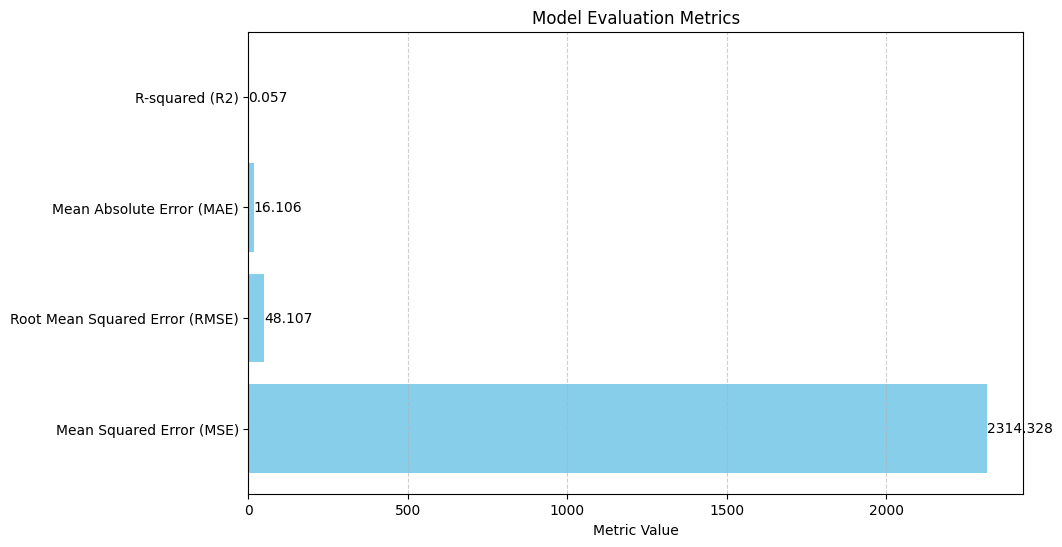

In [12]:
# Assuming you have the calculated metrics (mse, rmse, mae, r2)
metrics = ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R2)']
values = [mse, rmse, mae, r2]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color='skyblue')
plt.xlabel('Metric Value')
plt.title('Model Evaluation Metrics')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the values on the bars
for index, value in enumerate(values):
    plt.text(value, index, f'{value:.3f}', va='center', fontsize=10)

plt.show()

# Feature Importance

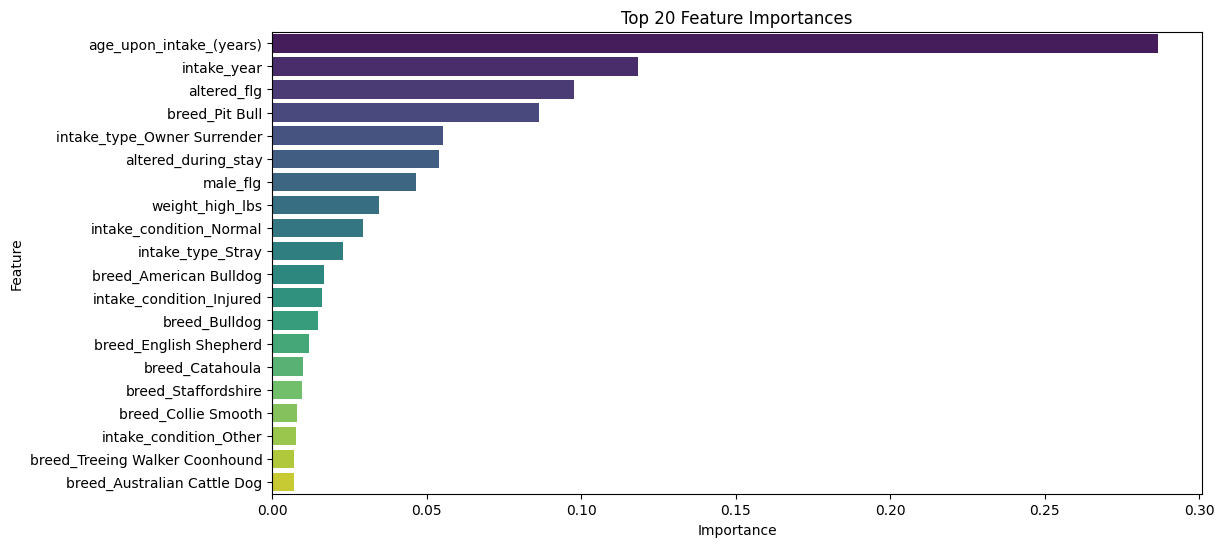

In [14]:
# If the best model is RandomForestRegressor, get feature importances
if isinstance(best_model.named_steps['regressor'], RandomForestRegressor):
    # Get feature importances
    feature_importances = best_model.named_steps['regressor'].feature_importances_

    # Get selected features from SelectKBest
    selected_features = best_model.named_steps['feature_selection'].get_support()

    # Create a DataFrame with feature names and their importance scores
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns[selected_features], 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the top coefficients
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Feature importances can only be visualized for RandomForestRegressor.")